In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/customer-segmentation-clustering/customer_segmentation.csv
/kaggle/input/customer-personality-analysis/marketing_campaign.csv


# *IMPORTING LIBRARIES*

In [2]:
import os
import numpy as np
import pandas as pd
import datetime
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt, numpy as np
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import AgglomerativeClustering
from matplotlib.colors import ListedColormap
from sklearn import metrics
import warnings
import sys
if not sys.warnoptions:
    warnings.simplefilter("ignore")
np.random.seed(42)

In [3]:
data = pd.read_csv("/kaggle/input/customer-personality-analysis/marketing_campaign.csv", sep="\t")
print("Number of datapoints:", len(data))
data.head()

Number of datapoints: 2240


,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

In [5]:
#To remove the NA values
data = data.dropna()
print("The total number of data-points after removing the rows with missing values are:", len(data))

The total number of data-points after removing the rows with missing values are: 2216


In [6]:
data["Dt_Customer"] = pd.to_datetime(data["Dt_Customer"], dayfirst=True)
dates = []
for i in data["Dt_Customer"]:
    i = i.date()
    dates.append(i)  
#Dates of the newest and oldest recorded customer
print("The newest customer's enrolment date in therecords:",max(dates))
print("The oldest customer's enrolment date in the records:",min(dates))

The newest customer's enrolment date in therecords: 2014-06-29
The oldest customer's enrolment date in the records: 2012-07-30


In [7]:
#Created a feature "Customer_For"
days = []
d1 = max(dates) #taking it to be the newest customer
for i in dates:
    delta = d1 - i
    days.append(delta)
data["Customer_For"] = days
data["Customer_For"] = pd.to_numeric(data["Customer_For"], errors="coerce")

In [8]:
print("Total categories in the feature Marital_Status:\n", data["Marital_Status"].value_counts(), "\n")
print("Total categories in the feature Education:\n", data["Education"].value_counts())

Total categories in the feature Marital_Status:
 Marital_Status
Married     857
Together    573
Single      471
Divorced    232
Widow        76
Alone         3
Absurd        2
YOLO          2
Name: count, dtype: int64 

Total categories in the feature Education:
 Education
Graduation    1116
PhD            481
Master         365
2n Cycle       200
Basic           54
Name: count, dtype: int64


In [9]:
#Feature Engineering
#Age of customer today 
data["Age"] = 2021-data["Year_Birth"]

#Total spendings on various items
data["Spent"] = data["MntWines"]+ data["MntFruits"]+ data["MntMeatProducts"]+ data["MntFishProducts"]+ data["MntSweetProducts"]+ data["MntGoldProds"]

#Deriving living situation by marital status"Alone"
data["Living_With"]=data["Marital_Status"].replace({"Married":"Partner", "Together":"Partner", "Absurd":"Alone", "Widow":"Alone", "YOLO":"Alone", "Divorced":"Alone", "Single":"Alone",})

#Feature indicating total children living in the household
data["Children"]=data["Kidhome"]+data["Teenhome"]

#Feature for total members in the householde
data["Family_Size"] = data["Living_With"].replace({"Alone": 1, "Partner":2})+ data["Children"]

#Feature pertaining parenthood
data["Is_Parent"] = np.where(data.Children> 0, 1, 0)

#Segmenting education levels in three groups
data["Education"]=data["Education"].replace({"Basic":"Undergraduate","2n Cycle":"Undergraduate", "Graduation":"Graduate", "Master":"Postgraduate", "PhD":"Postgraduate"})

#For clarity
data=data.rename(columns={"MntWines": "Wines","MntFruits":"Fruits","MntMeatProducts":"Meat","MntFishProducts":"Fish","MntSweetProducts":"Sweets","MntGoldProds":"Gold"})

#Dropping some of the redundant features
to_drop = ["Marital_Status", "Dt_Customer", "Z_CostContact", "Z_Revenue", "Year_Birth", "ID"]
data = data.drop(to_drop, axis=1)

In [10]:
data.describe()


,Income,Kidhome,Teenhome,Recency,Wines,Fruits,Meat,Fish,Sweets,Gold,...,AcceptedCmp1,AcceptedCmp2,Complain,Response,Customer_For,Age,Spent,Children,Family_Size,Is_Parent
count,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,...,2216.000000,2216.000000,2216.000000,2216.000000,2.216000e+03,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000
mean,52247.251354,0.441787,0.505415,49.012635,305.091606,26.356047,166.995939,37.637635,27.028881,43.965253,...,0.064079,0.013538,0.009477,0.150271,3.054423e+16,52.179603,607.075361,0.947202,2.592509,0.714350
std,25173.076661,0.536896,0.544181,28.948352,337.327920,39.793917,224.283273,54.752082,41.072046,51.815414,...,0.244950,0.115588,0.096907,0.357417,1.749036e+16,11.985554,602.900476,0.749062,0.905722,0.451825
min,1730.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000e+00,25.000000,5.000000,0.000000,1.000000,0.000000
25%,35303.000000,0.000000,0.000000,24.000000,24.000000,2.000000,16.000000,3.000000,1.000000,9.000000,...,0.000000,0.000000,0.000000,0.000000,1.555200e+16,44.000000,69.000000,0.000000,2.000000,0.000000
50%,51381.500000,0.000000,0.000000,49.000000,174.500000,8.000000,68.000000,12.000000,8.000000,24.500000,...,0.000000,0.000000,0.000000,0.000000,3.071520e+16,51.000000,396.500000,1.000000,3.000000,1.000000
75%,68522.000000,1.000000,1.000000,74.000000,505.000000,33.000000,232.250000,50.000000,33.000000,56.000000,...,0.000000,0.000000,0.000000,0.000000,4.570560e+16,62.000000,1048.000000,1.000000,3.000000,1.000000
max,666666.000000,2.000000,2.000000,99.000000,1493.000000,199.000000,1725.000000,259.000000,262.000000,321.000000,...,1.000000,1.000000,1.000000,1.000000,6.039360e+16,128.000000,2525.000000,3.000000,5.000000,1.000000


Reletive Plot Of Some Selected Features: A Data Subset


<Figure size 800x550 with 0 Axes>

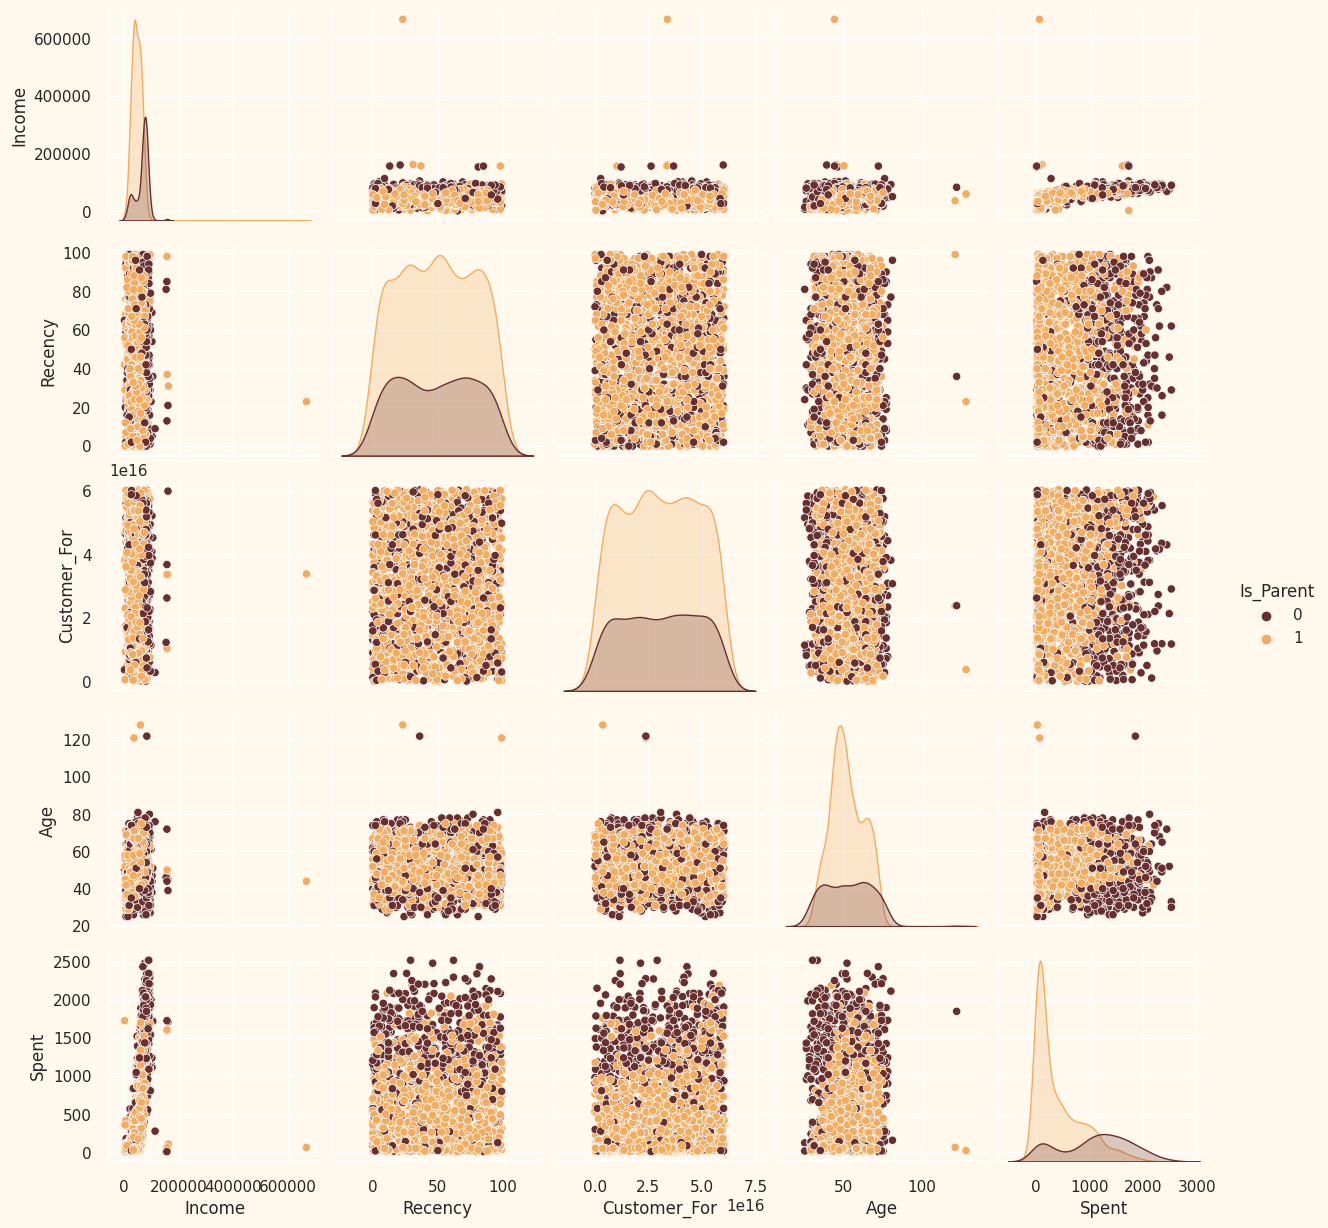

In [11]:
#To plot some selected features 
#Setting up colors prefrences
sns.set(rc={"axes.facecolor":"#FFF9ED","figure.facecolor":"#FFF9ED"})
pallet = ["#682F2F", "#9E726F", "#D6B2B1", "#B9C0C9", "#9F8A78", "#F3AB60"]
cmap = colors.ListedColormap(["#682F2F", "#9E726F", "#D6B2B1", "#B9C0C9", "#9F8A78", "#F3AB60"])
#Plotting following features
To_Plot = [ "Income", "Recency", "Customer_For", "Age", "Spent", "Is_Parent"]
print("Reletive Plot Of Some Selected Features: A Data Subset")
plt.figure()
sns.pairplot(data[To_Plot], hue= "Is_Parent",palette= (["#682F2F","#F3AB60"]))
#Taking hue 
plt.show()

In [12]:
#Dropping the outliers by setting a cap on Age and income. 
data = data[(data["Age"]<90)]
data = data[(data["Income"]<600000)]
print("The total number of data-points after removing the outliers are:", len(data))

The total number of data-points after removing the outliers are: 2212


<Axes: >

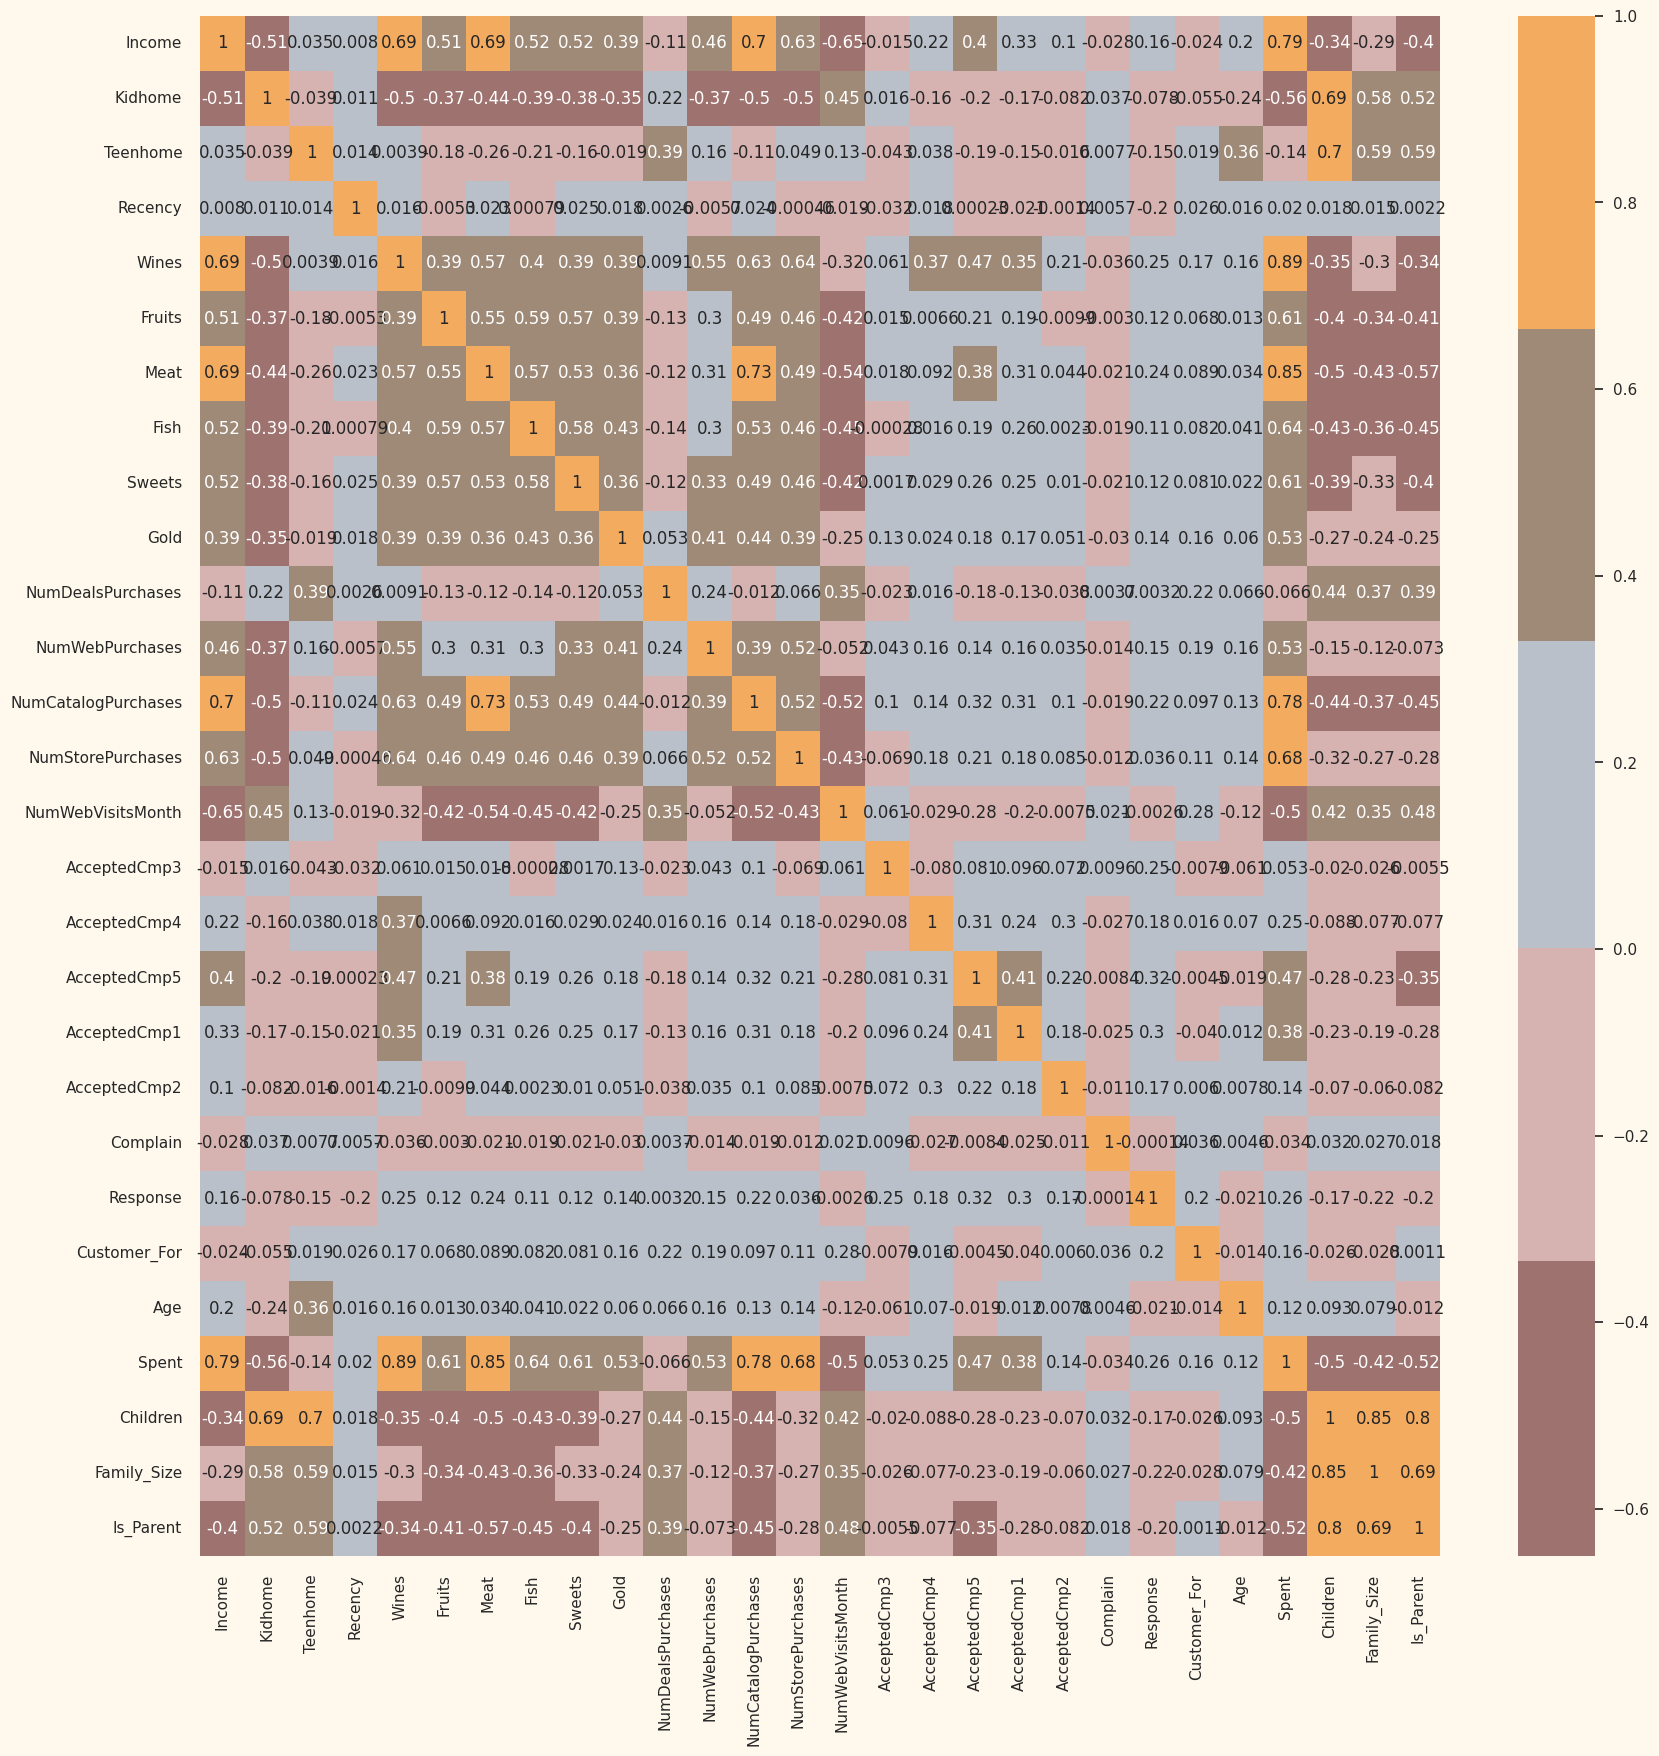

In [13]:
#correlation matrix
corrmat = data.corr(numeric_only=True)
plt.figure(figsize=(20,20))  
sns.heatmap(corrmat, annot=True, cmap=cmap, center=0)

# *DATA PREPROCESSING*

In [14]:
#Get list of categorical variables
s = (data.dtypes == 'object')
object_cols = list(s[s].index)

print("Categorical variables in the dataset:", object_cols)

Categorical variables in the dataset: ['Education', 'Living_With']


In [15]:
#Label Encoding the object dtypes.
LE=LabelEncoder()
for i in object_cols:
    data[i]=data[[i]].apply(LE.fit_transform)
    
print("All features are now numerical")

All features are now numerical


In [16]:
#Creating a copy of data
ds = data.copy()
# creating a subset of dataframe by dropping the features on deals accepted and promotions
cols_del = ['AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1','AcceptedCmp2', 'Complain', 'Response']
ds = ds.drop(cols_del, axis=1)
cols_del = ['Kidhome', 'Teenhome', 'Is_Parent','Living_With', 'Education']
ds = ds.drop(cols_del, axis=1)
#Scaling
scaler = StandardScaler()
scaler.fit(ds)
scaled_ds = pd.DataFrame(scaler.transform(ds),columns= ds.columns )
print("All features are now scaled")

All features are now scaled


In [17]:
#Scaled data to be used for reducing the dimensionality
print("Dataframe to be used for further modelling:")
scaled_ds.head()

Dataframe to be used for further modelling:


,Income,Recency,Wines,Fruits,Meat,Fish,Sweets,Gold,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Customer_For,Age,Spent,Children,Family_Size
0,0.287105,0.310353,0.977660,1.552041,1.690293,2.453472,1.483713,0.852576,0.351030,1.426865,2.503607,-0.555814,0.692181,1.527721,1.018352,1.676245,-1.264598,-1.758359
1,-0.260882,-0.380813,-0.872618,-0.637461,-0.718230,-0.651004,-0.634019,-0.733642,-0.168701,-1.126420,-0.571340,-1.171160,-0.132545,-1.189011,1.274785,-0.963297,1.404572,0.449070
2,0.913196,-0.795514,0.357935,0.570540,-0.178542,1.339513,-0.147184,-0.037254,-0.688432,1.426865,-0.229679,1.290224,-0.544908,-0.206048,0.334530,0.280110,-1.264598,-0.654644
3,-1.176114,-0.795514,-0.872618,-0.561961,-0.655787,-0.504911,-0.585335,-0.752987,-0.168701,-0.761665,-0.913000,-0.555814,0.279818,-1.060584,-1.289547,-0.920135,0.069987,0.449070
4,0.294307,1.554453,-0.392257,0.419540,-0.218684,0.152508,-0.001133,-0.559545,1.390492,0.332600,0.111982,0.059532,-0.132545,-0.951915,-1.033114,-0.307562,0.069987,0.449070


# *DIMENSIONALITY REDUCTION*

In [18]:
#Initiating PCA to reduce dimentions aka features to 3
pca = PCA(n_components=3)
pca.fit(scaled_ds)
PCA_ds = pd.DataFrame(pca.transform(scaled_ds), columns=(["col1","col2", "col3"]))
PCA_ds.describe().T

,count,mean,std,min,25%,50%,75%,max
col1,2212.0,-2.248553e-17,2.705212,-5.648014,-2.398294,-0.812656,2.357906,7.344110
col2,2212.0,2.890997e-17,1.453622,-3.596880,-1.069937,-0.189668,0.890911,6.145305
col3,2212.0,3.372829e-17,1.159007,-3.723350,-0.786679,-0.011252,0.778543,5.700317


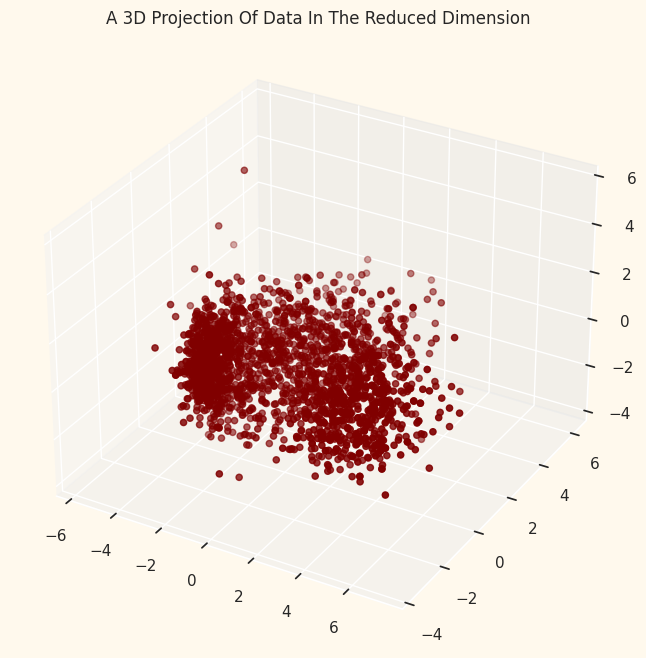

In [19]:
#A 3D Projection Of Data In The Reduced Dimension
x =PCA_ds["col1"]
y =PCA_ds["col2"]
z =PCA_ds["col3"]
#To plot
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(x,y,z, c="maroon", marker="o" )
ax.set_title("A 3D Projection Of Data In The Reduced Dimension")
plt.show()

<Axes: >

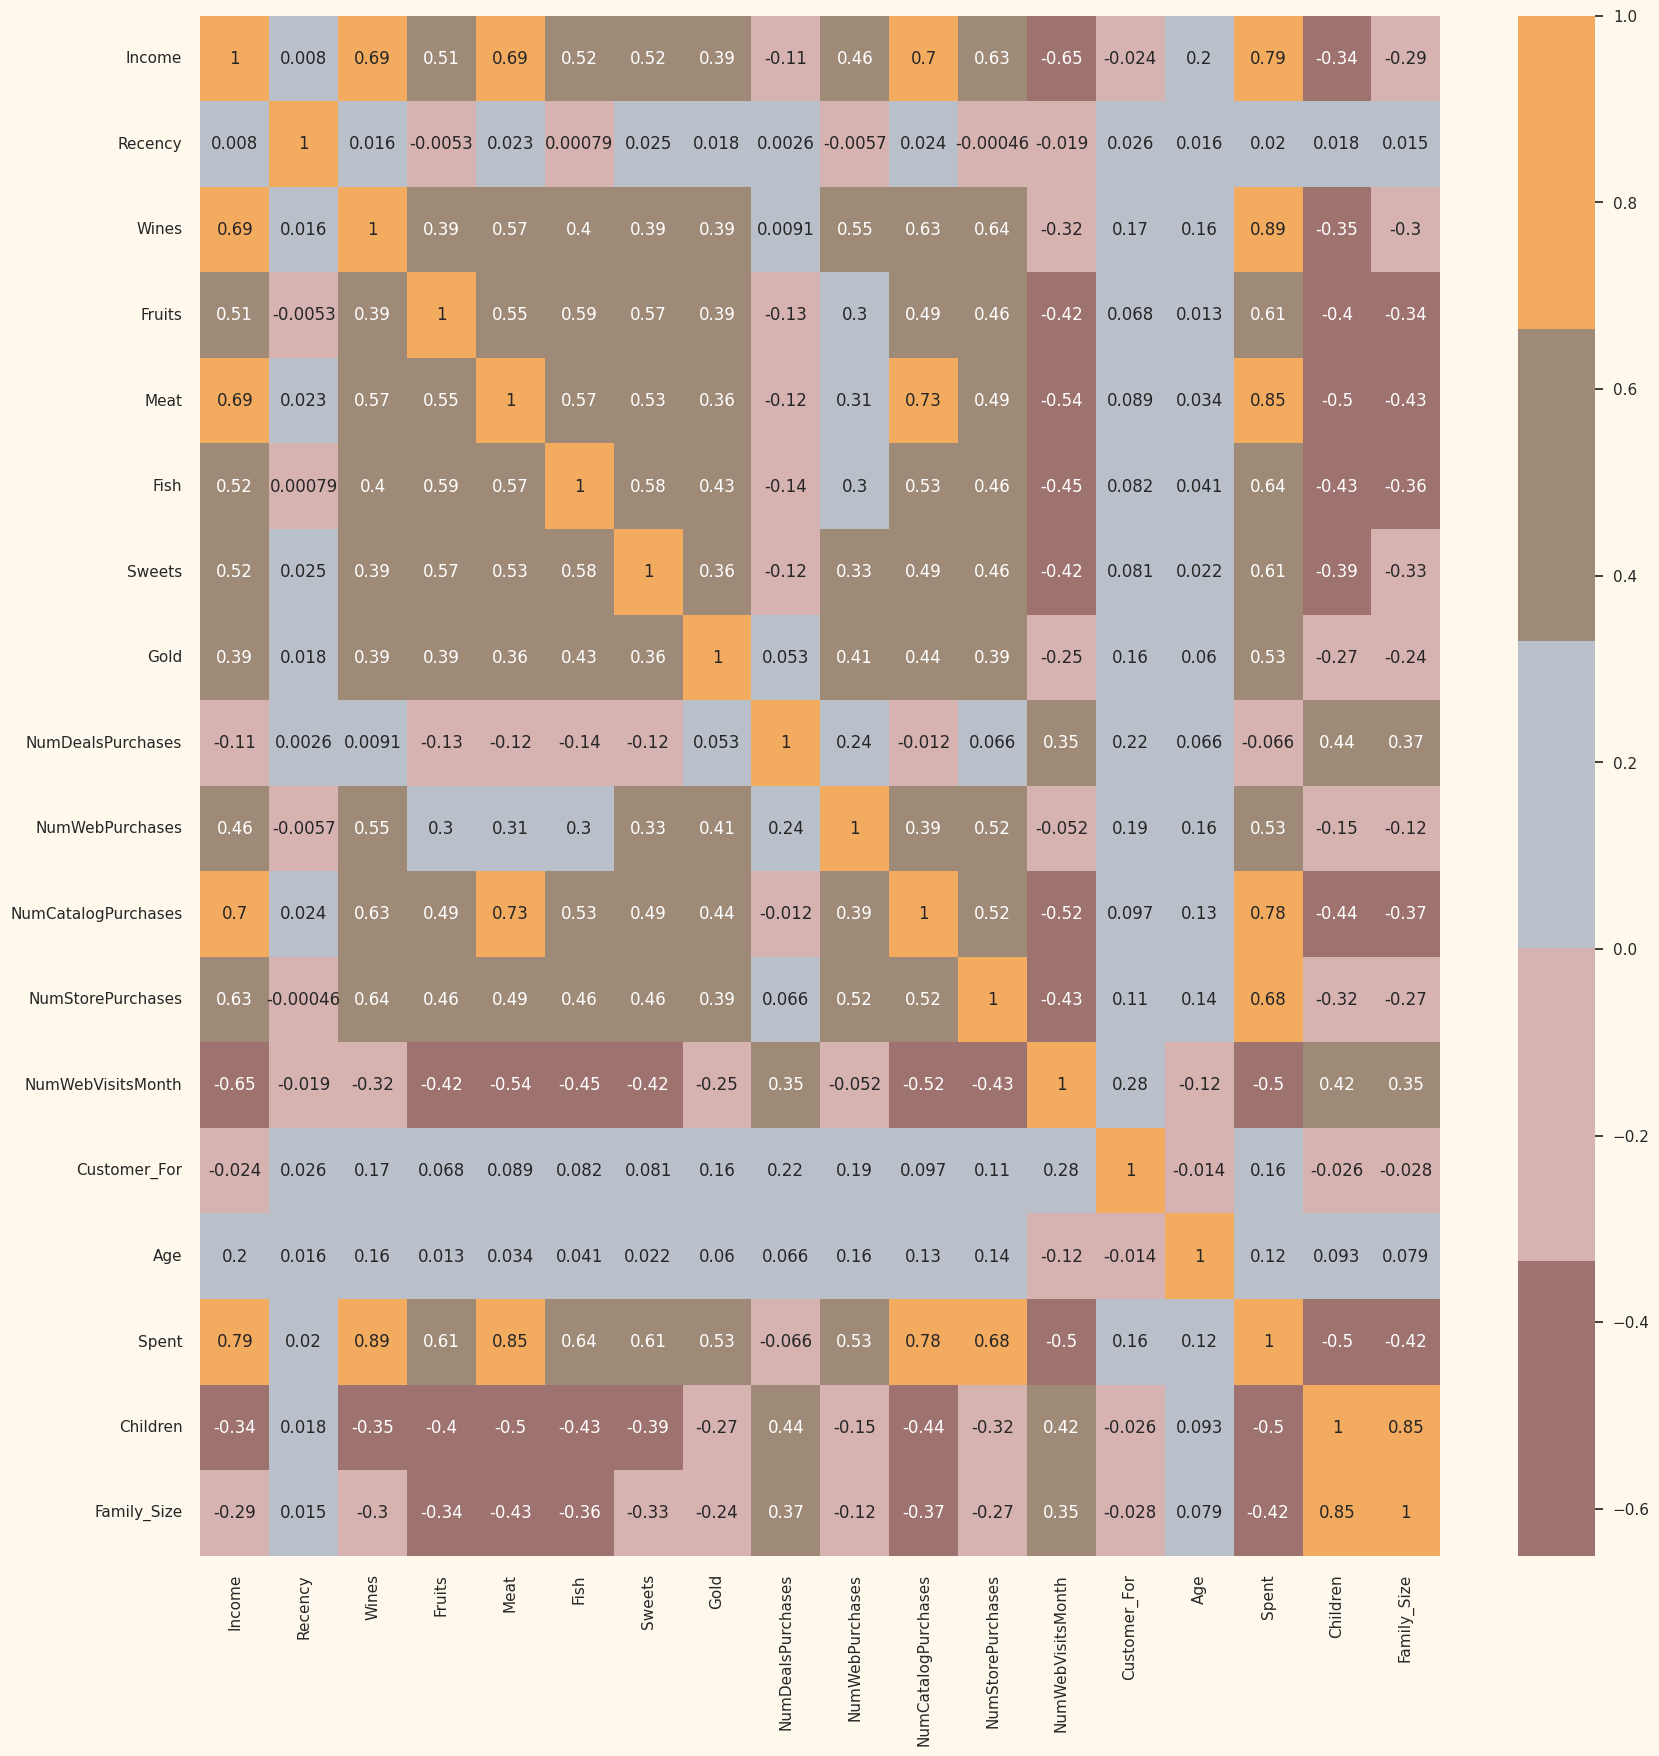

In [20]:
#correlation matrix
corrmat = ds.corr(numeric_only=True)
plt.figure(figsize=(20,20))  
sns.heatmap(corrmat, annot=True, cmap=cmap, center=0)

In [21]:
# import numpy as np
# from sklearn.metrics import silhouette_score
# from deap import base, creator, tools, algorithms
# from multiprocessing import Pool
# import random

# class AdaptiveGAClustering:
#     def __init__(self, n_clusters=3, pop_size=50, n_gen=100, cxpb=0.8, mutpb=0.2, 
#                  adaptive_params=True, min_clusters=2, max_clusters=10):
#         """
#         Adaptive Genetic Algorithm for Clustering
        
#         Parameters:
#         - n_clusters: Initial number of clusters (will adapt if adaptive_params=True)
#         - pop_size: Population size
#         - n_gen: Number of generations
#         - cxpb: Crossover probability
#         - mutpb: Mutation probability
#         - adaptive_params: Whether to adapt cluster numbers and GA parameters
#         - min_clusters: Minimum number of clusters (if adaptive)
#         - max_clusters: Maximum number of clusters (if adaptive)
#         """
#         self.n_clusters = n_clusters
#         self.pop_size = pop_size
#         self.n_gen = n_gen
#         self.cxpb = cxpb
#         self.mutpb = mutpb
#         self.adaptive_params = adaptive_params
#         self.min_clusters = min_clusters
#         self.max_clusters = max_clusters
#         self.toolbox = None
#         self.logbook = None
#         self.best_ind = None
#         self.best_score = -np.inf
#         self.best_n_clusters = n_clusters
        
#     def _setup_ga(self, data):
#         """Setup DEAP framework components"""
#         # Create fitness and individual classes
#         creator.create("FitnessMax", base.Fitness, weights=(1.0,))
        
#         if self.adaptive_params:
#             # Individual includes cluster centers and number of clusters
#             creator.create("Individual", list, fitness=creator.FitnessMax, n_clusters=int)
#         else:
#             # Individual is just cluster centers
#             creator.create("Individual", list, fitness=creator.FitnessMax)
        
#         self.toolbox = base.Toolbox()
        
#         # Attribute generator for cluster centers
#         def random_center():
#             return random.uniform(data.min(), data.max())
        
#         # Initialize population
#         if self.adaptive_params:
#             # For adaptive version, we need to generate individuals with variable cluster counts
#             def init_individual():
#                 n_clusters = random.randint(self.min_clusters, self.max_clusters)
#                 centers = [random_center() for _ in range(n_clusters * data.shape[1])]
#                 ind = creator.Individual(centers)
#                 ind.n_clusters = n_clusters
#                 return ind
            
#             self.toolbox.register("individual", init_individual)
#         else:
#             # For fixed version, all individuals have same number of clusters
#             self.toolbox.register("attr_float", random_center)
#             self.toolbox.register("individual", tools.initRepeat, creator.Individual, 
#                                  self.toolbox.attr_float, n=self.n_clusters * data.shape[1])
        
#         self.toolbox.register("population", tools.initRepeat, list, self.toolbox.individual)
        
#         # Register genetic operators
#         self.toolbox.register("mate", tools.cxBlend, alpha=0.5)
#         self.toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=1, indpb=0.2)
#         self.toolbox.register("select", tools.selTournament, tournsize=3)
#         self.toolbox.register("evaluate", self._evaluate, data=data)
        
#     def _evaluate(self, individual, data):
#         """Evaluate clustering quality using silhouette score"""
#         if self.adaptive_params:
#             n_clusters = individual.n_clusters
#             centers = np.array(individual).reshape(n_clusters, data.shape[1])
#         else:
#             n_clusters = self.n_clusters
#             centers = np.array(individual).reshape(n_clusters, data.shape[1])
        
#         # Calculate distances from each point to each center
#         distances = np.array([np.linalg.norm(data - center, axis=1) for center in centers])
        
#         # Assign each point to the closest center
#         labels = np.argmin(distances, axis=0)
        
#         # Calculate silhouette score (handle cases where all points are in one cluster)
#         if len(np.unique(labels)) < 2:
#             return -1,  # Invalid clustering
            
#         score = silhouette_score(data, labels)
        
#         # Store best solution found
#         if score > self.best_score:
#             self.best_score = score
#             self.best_ind = individual
#             if self.adaptive_params:
#                 self.best_n_clusters = individual.n_clusters
        
#         return score,
    
#     def _adaptive_parameters(self, gen):
#         """Adapt GA parameters based on generation"""
#         # Linear decrease in mutation probability
#         self.mutpb = max(0.05, 0.5 - (0.45 * gen / self.n_gen))
        
#         # Increase selection pressure over time
#         if gen % 10 == 0 and gen > 0:
#             self.toolbox.register("select", tools.selTournament, tournsize=min(5, 3 + gen//20))
    
#     def fit(self, data):
#         """Run the genetic algorithm clustering"""
#         self._setup_ga(data)
#         pop = self.toolbox.population(n=self.pop_size)
#         hof = tools.HallOfFame(1)
#         stats = tools.Statistics(lambda ind: ind.fitness.values)
#         stats.register("avg", np.mean)
#         stats.register("min", np.min)
#         stats.register("max", np.max)
        
#         for gen in range(self.n_gen):
#             if self.adaptive_params:
#                 self._adaptive_parameters(gen)
            
#             # Select and clone the next generation individuals
#             offspring = self.toolbox.select(pop, len(pop))
#             offspring = list(map(self.toolbox.clone, offspring))
            
#             # Apply crossover and mutation
#             for child1, child2 in zip(offspring[::2], offspring[1::2]):
#                 if random.random() < self.cxpb:
#                     self.toolbox.mate(child1, child2)
#                     del child1.fitness.values
#                     del child2.fitness.values
            
#             for mutant in offspring:
#                 if random.random() < self.mutpb:
#                     self.toolbox.mutate(mutant)
#                     del mutant.fitness.values
            
#             # Evaluate the individuals with an invalid fitness
#             invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
#             fitnesses = self.toolbox.map(self.toolbox.evaluate, invalid_ind)
#             for ind, fit in zip(invalid_ind, fitnesses):
#                 ind.fitness.values = fit
            
#             # Replace population
#             pop[:] = offspring
            
#             # Update hall of fame
#             hof.update(pop)
            
#             # Record statistics
#             if self.logbook is None:
#                 self.logbook = tools.Logbook()
#             self.logbook.record(gen=gen, **stats.compile(pop))
        
#         # Store best solution
#         self.best_ind = hof[0]
#         if self.adaptive_params:
#             self.best_n_clusters = self.best_ind.n_clusters
#         else:
#             self.best_n_clusters = self.n_clusters
        
#         return self
    
#     def predict(self, data):
#         """Predict cluster labels for new data"""
#         centers = np.array(self.best_ind).reshape(self.best_n_clusters, data.shape[1])
#         distances = np.array([np.linalg.norm(data - center, axis=1) for center in centers])
#         return np.argmin(distances, axis=0)
    
#     def get_cluster_centers(self):
#         """Get the final cluster centers"""
#         return np.array(self.best_ind).reshape(self.best_n_clusters, -1)
    
#     def get_best_score(self):
#         """Get the best silhouette score found"""
#         return self.best_score
    
#     def predict(self, data):
#         """Predict cluster labels for new data"""
#         centers = np.array(self.best_ind).reshape(self.best_n_clusters, data.shape[1])
#         distances = np.array([np.linalg.norm(data - center, axis=1) for center in centers])
#         return np.argmin(distances, axis=0)
    
#     def get_cluster_centers(self):
#         """Get the final cluster centers"""
#         return np.array(self.best_ind).reshape(self.best_n_clusters, -1)
    
#     def get_best_score(self):
#         """Get the best silhouette score found"""
#         return self.best_score

In [22]:
# # Initialize the adaptive GA clustering
# ga_cluster = AdaptiveGAClustering(
#     n_clusters=4, 
#     pop_size=100,  # Increased from 50
#     n_gen=200,     # Increased from 100
#     adaptive_params=True, 
#     min_clusters=2, 
#     max_clusters=8
# )

In [23]:
# # Fit to your PCA-reduced data
# ga_cluster.fit(PCA_ds.values)

In [24]:
# # Get predictions
# ga_labels = ga_cluster.predict(PCA_ds.values)

In [25]:
# # the optimal number of clusters found
# optimal_clusters = ga_cluster.best_n_clusters
# print(f"Optimal number of clusters found: {optimal_clusters}")
# print(f"Best silhouette score: {ga_cluster.get_best_score():.4f}")

In [26]:
# # Visualize the clusters
# fig = plt.figure(figsize=(10,8))
# ax = fig.add_subplot(111, projection="3d")
# x = PCA_ds["col1"]
# y = PCA_ds["col2"]
# z = PCA_ds["col3"]
# ax.scatter(x, y, z, c=ga_labels, cmap='viridis', marker='o')
# ax.set_title(f"GA Clustering (k={optimal_clusters}) - 3D Projection")
# plt.show()

In [27]:
# import numpy as np
# from sklearn.metrics import silhouette_score
# from sklearn.metrics import pairwise_distances_argmin
# import matplotlib.pyplot as plt
# import random 

# def initialize_population(X, n_clusters, population_size):
#     population = []
#     for _ in range(population_size):
#         indices = np.random.choice(X.shape[0], n_clusters, replace=False)
#         centroids = X[indices]
#         population.append(centroids)
#     return population

# def assign_clusters(X, centroids):
#     labels = pairwise_distances_argmin(X, centroids)
#     return labels

# def calculate_fitness(X, centroids):
#     labels = assign_clusters(X, centroids)
#     try:
#         score = silhouette_score(X, labels)
#     except:
#         score = -1  # Invalid clustering
#     return score

# def select_parents(population, fitness_scores, n_parents):
#     parents = [population[i] for i in np.argsort(fitness_scores)[-n_parents:]]
#     return parents

# def crossover(parent1, parent2):
#     alpha = np.random.rand()
#     child = alpha * parent1 + (1 - alpha) * parent2
#     return child

# def mutate(centroids, mutation_rate, X):
#     for i in range(centroids.shape[0]):
#         if np.random.rand() < mutation_rate:
#             noise = np.random.normal(0, 0.1, centroids.shape[1])
#             centroids[i] += noise
#             centroids[i] = np.clip(centroids[i], X.min(axis=0), X.max(axis=0))
#     return centroids

# def genetic_algorithm_clustering(X, n_clusters, population_size=10, generations=80, 
#                                  init_mutation_rate=0.2, n_parents=5, 
#                                  adapt_factor=1.05, patience=10, early_stop=True):
#     population = initialize_population(X, n_clusters, population_size)
#     best_score = -1
#     best_centroids = None
#     stagnation_counter = 0
#     mutation_rate = init_mutation_rate

#     for gen in range(generations):
#         fitness_scores = [calculate_fitness(X, centroids) for centroids in population]
#         gen_best_score = max(fitness_scores)
#         gen_best_centroids = population[np.argmax(fitness_scores)]

#         if gen_best_score > best_score:
#             best_score = gen_best_score
#             best_centroids = gen_best_centroids
#             stagnation_counter = 0
#         else:
#             stagnation_counter += 1

#         # Adaptive mutation rate
#         if stagnation_counter > 0:
#             mutation_rate *= adapt_factor
#         else:
#             mutation_rate *= 0.95
#         mutation_rate = np.clip(mutation_rate, 0.01, 0.6)

#         print(f"Generation {gen+1} | Best Silhouette Score: {best_score:.4f} | Mutation Rate: {mutation_rate:.3f}")

#         if early_stop and stagnation_counter >= patience:
#             print("Early stopping: No improvement for", patience, "generations.")
#             break

#         parents = select_parents(population, fitness_scores, n_parents)
#         next_population = parents.copy()

#         while len(next_population) < population_size:
#             p1, p2 = random.sample(parents, 2)
#             child = crossover(p1, p2)
#             child = mutate(child, mutation_rate, X)
#             next_population.append(child)

#         population = next_population

#     labels = assign_clusters(X, best_centroids)
#     return labels, best_centroids, best_score


In [28]:
# X = PCA_ds.values

# labels, centroids, best_score = genetic_algorithm_clustering(
#     X,
#     n_clusters=5,
#     population_size=10,
#     generations=80,
#     init_mutation_rate=0.2,
#     n_parents=5,
#     adapt_factor=1.05,      # how fast mutation increases
#     patience=20,            # stop if no improvement for 20 gens
#     early_stop=True
# )

# print("Best Silhouette Score:", best_score)

# # Optional: 3D Plot
# fig = plt.figure(figsize=(10, 8))
# ax = fig.add_subplot(111, projection='3d')
# ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=labels, cmap='Set1', s=50)
# ax.set_title("Adaptive Genetic Algorithm Clustering")
# plt.show()


In [29]:
# import numpy as np
# from sklearn.metrics import silhouette_score
# from sklearn.metrics import pairwise_distances_argmin
# import matplotlib.pyplot as plt
# import random

# def initialize_population(X, n_clusters, population_size):
#     """Initialize population using k-means++ inspired initialization"""
#     population = []
#     for _ in range(population_size):
#         # Select first centroid randomly
#         centroids = [X[np.random.randint(X.shape[0])]]
        
#         # Select remaining centroids using probability proportional to distance
#         for _ in range(1, n_clusters):
#             distances = np.array([min([np.linalg.norm(x - c) for c in centroids]) for x in X])
#             probabilities = distances / distances.sum()
#             cumulative_prob = probabilities.cumsum()
#             r = random.random()
#             for j, p in enumerate(cumulative_prob):
#                 if r < p:
#                     centroids.append(X[j])
#                     break
#         population.append(np.array(centroids))
#     return population

# def assign_clusters(X, centroids):
#     """Assign points to nearest centroid"""
#     return pairwise_distances_argmin(X, centroids)

# def calculate_fitness(X, centroids):
#     """Calculate silhouette score with better handling of edge cases"""
#     labels = assign_clusters(X, centroids)
#     unique_labels = np.unique(labels)
    
#     if len(unique_labels) == 1:
#         return -1  # All points in one cluster
    
#     # For very small clusters, reduce score
#     min_cluster_size = min(np.bincount(labels))
#     penalty = 0.5 if min_cluster_size < 5 else 1.0
    
#     try:
#         score = silhouette_score(X, labels) * penalty
#     except:
#         score = -1
#     return score

# def select_parents(population, fitness_scores, n_parents, tournament_size=3):
#     """Tournament selection with adjustable size"""
#     parents = []
#     for _ in range(n_parents):
#         candidates = random.sample(range(len(population)), tournament_size)
#         winner = max(candidates, key=lambda x: fitness_scores[x])
#         parents.append(population[winner])
#     return parents

# def crossover(parent1, parent2, crossover_rate=0.8):
#     """Blend crossover with probability"""
#     if random.random() < crossover_rate:
#         alpha = np.random.rand()
#         child = alpha * parent1 + (1 - alpha) * parent2
#     else:
#         child = parent1 if random.random() < 0.5 else parent2
#     return child

# def mutate(centroids, mutation_rate, X, mutation_scale=0.1):
#     """Gaussian mutation with adaptive scale"""
#     mutated = centroids.copy()
#     for i in range(centroids.shape[0]):
#         if random.random() < mutation_rate:
#             scale = mutation_scale * (X.max(axis=0) - X.min(axis=0))
#             mutated[i] += np.random.normal(0, scale, size=centroids.shape[1])
#             mutated[i] = np.clip(mutated[i], X.min(axis=0), X.max(axis=0))
#     return mutated

# def genetic_algorithm_clustering(X, n_clusters, population_size=20, generations=100, 
#                                init_mutation_rate=0.2, n_parents=5, 
#                                adapt_factor=1.05, patience=10, early_stop=True):
#     """Improved adaptive GA clustering"""
#     # Initialize
#     population = initialize_population(X, n_clusters, population_size)
#     best_score = -np.inf
#     best_centroids = None
#     stagnation_counter = 0
#     mutation_rate = init_mutation_rate
#     history = []
    
#     for gen in range(generations):
#         # Evaluation
#         fitness_scores = [calculate_fitness(X, centroids) for centroids in population]
#         gen_best_idx = np.argmax(fitness_scores)
#         gen_best_score = fitness_scores[gen_best_idx]
#         gen_best_centroids = population[gen_best_idx]
        
#         # Update best solution
#         if gen_best_score > best_score:
#             best_score = gen_best_score
#             best_centroids = gen_best_centroids
#             stagnation_counter = 0
#         else:
#             stagnation_counter += 1
        
#         history.append(best_score)
        
#         # Adaptive mutation
#         mutation_rate = min(0.5, max(0.01, mutation_rate * (adapt_factor if stagnation_counter > 0 else 0.95)))
        
#         print(f"Gen {gen+1:3d} | Best: {best_score:.4f} | Mut: {mutation_rate:.3f} | Stag: {stagnation_counter}")
        
#         # Early stopping
#         if early_stop and stagnation_counter >= patience:
#             print(f"Early stopping at generation {gen+1}")
#             break
        
#         # Selection
#         parents = select_parents(population, fitness_scores, n_parents)
        
#         # Reproduction
#         next_population = parents.copy()
#         while len(next_population) < population_size:
#             p1, p2 = random.sample(parents, 2)
#             child = crossover(p1, p2)
#             child = mutate(child, mutation_rate, X)
#             next_population.append(child)
        
#         population = next_population
    
#     labels = assign_clusters(X, best_centroids)
#     return labels, best_centroids, best_score, history

In [30]:
# # Usage example
# X = PCA_ds.values

# labels, centroids, best_score, history = genetic_algorithm_clustering(
#     X,
#     n_clusters=5,
#     population_size=20,
#     generations=100,
#     init_mutation_rate=0.2,
#     n_parents=5,
#     adapt_factor=1.02,  # More conservative adaptation
#     patience=15,
#     early_stop=True
# )

# print("Best Silhouette Score:", best_score)

# # Plot convergence
# plt.figure(figsize=(10, 5))
# plt.plot(history, marker='o')
# plt.title("GA Clustering Convergence")
# plt.xlabel("Generation")
# plt.ylabel("Best Silhouette Score")
# plt.grid(True)
# plt.show()

# # 3D Plot
# fig = plt.figure(figsize=(10, 8))
# ax = fig.add_subplot(111, projection='3d')
# ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=labels, cmap='viridis', s=50)
# ax.set_title("Adaptive GA Clustering Result")
# plt.show()

In [31]:
# import numpy as np
# from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score
# from scipy.spatial.distance import cdist
# import random

# class AdaptiveGAClusterer:
#     def __init__(self, max_clusters=10, pop_size=50, max_gens=200):
#         self.max_clusters = max_clusters
#         self.pop_size = pop_size
#         self.max_gens = max_gens
#         self.best_k = None
#         self.best_centroids = None
#         self.best_score = -np.inf
        
#     def _init_individual(self, X):
#         """Create individual with variable cluster count"""
#         k = random.randint(2, self.max_clusters)
#         centroids = X[np.random.choice(X.shape[0], k, replace=False)]
#         return {'k': k, 'centroids': centroids, 'mut_rate': 0.2, 'cross_rate': 0.8}
    
#     def _calculate_fitness(self, X, individual):
#         """Adaptive fitness with multiple criteria"""
#         k, centroids = individual['k'], individual['centroids']
        
#         # Cluster validity metrics
#         labels = pairwise_distances_argmin(X, centroids)
#         unique_labels = np.unique(labels)
        
#         # Penalties for bad configurations
#         if len(unique_labels) < 2 or min(np.bincount(labels)) < 5:
#             return -np.inf
        
#         ch_score = calinski_harabasz_score(X, labels)
#         db_score = davies_bouldin_score(X, labels)
#         dist_penalty = np.log(np.min(cdist(centroids, centroids) + 1e-6))
        
#         # Composite score (higher is better)
#         return 0.5*ch_score - 0.4*db_score + 0.1*dist_penalty
    
#     def _adapt_rates(self, individual, improvement):
#         """Dynamically adjust mutation/crossover rates"""
#         if improvement > 0:
#             # Reward successful parameters
#             individual['mut_rate'] *= 0.95
#             individual['cross_rate'] *= 1.05
#         else:
#             # Encourage exploration
#             individual['mut_rate'] *= 1.05
#             individual['cross_rate'] *= 0.95
            
#         # Keep within bounds
#         individual['mut_rate'] = np.clip(individual['mut_rate'], 0.05, 0.5)
#         individual['cross_rate'] = np.clip(individual['cross_rate'], 0.5, 0.95)
#         return individual
    
#     def _crossover(self, parent1, parent2, X):
#         """Adaptive crossover with cluster count blending"""
#         # Blend cluster counts
#         new_k = random.randint(
#             min(parent1['k'], parent2['k']),
#             max(parent1['k'], parent2['k'])
#         )
        
#         # Combine centroids from both parents
#         all_centroids = np.vstack([parent1['centroids'], parent2['centroids']])
#         selected = random.sample(range(len(all_centroids)), new_k)
        
#         return {
#             'k': new_k,
#             'centroids': all_centroids[selected],
#             'mut_rate': (parent1['mut_rate'] + parent2['mut_rate'])/2,
#             'cross_rate': (parent1['cross_rate'] + parent2['cross_rate'])/2
#         }
    
#     def _mutate(self, individual, X):
#         """Adaptive mutation with cluster operations"""
#         k, centroids = individual['k'], individual['centroids']
        
#         # Cluster count mutation (10% chance)
#         if random.random() < 0.1:
#             new_k = k + random.choice([-1, 1])
#             new_k = max(2, min(new_k, self.max_clusters))
            
#             if new_k > k:
#                 # Add new centroid
#                 new_center = X[random.randint(0, X.shape[0]-1)]
#                 centroids = np.vstack([centroids, new_center])
#             elif new_k < k:
#                 # Remove random centroid
#                 centroids = centroids[random.sample(range(k), new_k)]
#             k = new_k
        
#         # Centroid position mutation
#         for i in range(k):
#             if random.random() < individual['mut_rate']:
#                 mutation_strength = 0.1 * (X.max(axis=0) - X.min(axis=0))
#                 centroids[i] += np.random.normal(0, mutation_strength)
                
#         individual['centroids'] = centroids
#         individual['k'] = k
#         return individual
    
#     def _local_search(self, individual, X, max_iter=3):
#         """K-means refinement for local optimization"""
#         centroids = individual['centroids']
#         for _ in range(max_iter):
#             labels = pairwise_distances_argmin(X, centroids)
#             new_centroids = np.array([
#                 X[labels == i].mean(axis=0) if sum(labels == i) > 0 
#                 else centroids[i] 
#                 for i in range(individual['k'])
#             ])
#             if np.allclose(centroids, new_centroids, atol=1e-4):
#                 break
#             centroids = new_centroids
#         individual['centroids'] = centroids
#         return individual
    
#     def fit(self, X):
#         # Initialize population
#         population = [self._init_individual(X) for _ in range(self.pop_size)]
        
#         for gen in range(self.max_gens):
#             # Evaluate and rank
#             fitness = [self._calculate_fitness(X, ind) for ind in population]
#             ranked_indices = np.argsort(fitness)[::-1]
            
#             # Update best solution
#             current_best = population[ranked_indices[0]]
#             current_score = fitness[ranked_indices[0]]
            
#             if current_score > self.best_score:
#                 improvement = current_score - self.best_score
#                 self.best_score = current_score
#                 self.best_k = current_best['k']
#                 self.best_centroids = current_best['centroids']
#             else:
#                 improvement = 0
            
#             # Adaptive parameter updates
#             for idx in ranked_indices[:self.pop_size//2]:  # Only top performers
#                 population[idx] = self._adapt_rates(population[idx], improvement)
            
#             # Elitism - keep top 10%
#             new_population = [population[i] for i in ranked_indices[:self.pop_size//10]]
            
#             # Reproduction
#             while len(new_population) < self.pop_size:
#                 # Tournament selection
#                 candidates = random.sample(range(self.pop_size), min(5, self.pop_size//2))
#                 parent1 = population[max(candidates, key=lambda x: fitness[x])]
#                 candidates = random.sample(range(self.pop_size), min(5, self.pop_size//2))
#                 parent2 = population[max(candidates, key=lambda x: fitness[x])]
                
#                 # Crossover with adaptive probability
#                 if random.random() < (parent1['cross_rate'] + parent2['cross_rate'])/2:
#                     child = self._crossover(parent1, parent2, X)
#                 else:
#                     child = random.choice([parent1, parent2])
                
#                 # Mutation
#                 child = self._mutate(child, X)
                
#                 # Local search on 20% of offspring
#                 if random.random() < 0.2:
#                     child = self._local_search(child, X)
                
#                 new_population.append(child)
            
#             population = new_population
            
#             # Progress tracking
#             if gen % 10 == 0:
#                 print(f"Gen {gen}: Best k={self.best_k} Score={self.best_score:.3f} "
#                       f"Avg Mut={np.mean([ind['mut_rate'] for ind in population]):.3f}")
        
#         # Final refinement
#         self.best_centroids = self._local_search({
#             'k': self.best_k,
#             'centroids': self.best_centroids
#         }, X, max_iter=10)['centroids']
        
#         return self
    
#     def predict(self, X):
#         return pairwise_distances_argmin(X, self.best_centroids)

In [32]:
# # Usage Example
# clusterer = AdaptiveGAClusterer(max_clusters=8, pop_size=50, max_gens=100)
# clusterer.fit(PCA_ds.values)
# labels = clusterer.predict(PCA_ds.values)

# print(f"\nOptimal clusters found: {clusterer.best_k}")
# print(f"Final fitness score: {clusterer.best_score:.3f}")

# # Visualization
# fig = plt.figure(figsize=(12, 8))
# ax = fig.add_subplot(111, projection='3d')
# ax.scatter(PCA_ds.values[:, 0], PCA_ds.values[:, 1], PCA_ds.values[:, 2], 
#            c=labels, cmap='viridis', s=40, alpha=0.8)
# ax.scatter(clusterer.best_centroids[:, 0], clusterer.best_centroids[:, 1],
#            clusterer.best_centroids[:, 2], c='red', marker='X', s=200)
# plt.title(f"Adaptive GA Clustering (k={clusterer.best_k}, Score={clusterer.best_score:.3f})")
# plt.show()

In [33]:
import numpy as np
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import cdist
import random
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from collections import Counter
from sklearn.metrics import pairwise_distances_argmin

class AutoClusterGA:
    def __init__(self, max_clusters=10, pop_size=100, max_gens=200, 
                 elite_frac=0.1, mutation_range=(0.1, 0.5), 
                 crossover_range=(0.6, 0.95), n_jobs=-1):
        """
        Adaptive GA for automatic clustering
        
        Parameters:
        - max_clusters: Maximum number of clusters to consider
        - pop_size: Population size
        - max_gens: Maximum generations
        - elite_frac: Fraction of elite individuals preserved
        - mutation_range: Min/max mutation rates
        - crossover_range: Min/max crossover rates
        - n_jobs: Number of parallel jobs (-1 for all cores)
        """
        self.max_clusters = max_clusters
        self.pop_size = pop_size
        self.max_gens = max_gens
        self.elite_size = int(pop_size * elite_frac)
        self.mutation_range = mutation_range
        self.crossover_range = crossover_range
        self.n_jobs = n_jobs
        self.best_k = None
        self.best_centroids = None
        self.best_score = -np.inf
        self.history = []

    def _initialize_individual(self, X):
        """Create individual with biased k initialization"""
        # Favor mid-range k values (3-7) more than extremes
        weights = [1/((k-4)**2 + 1) for k in range(2, self.max_clusters+1)]
        k = random.choices(range(2, self.max_clusters+1), weights=weights)[0]
        
        # k-means++ initialization
        centroids = [X[np.random.choice(X.shape[0])]]
        for _ in range(1, k):
            dists = np.min(cdist(X, centroids), axis=1)
            probs = dists / (dists.sum() + 1e-6)
            centroids.append(X[np.random.choice(X.shape[0], p=probs)])
        
        return {
            'k': k,
            'centroids': np.array(centroids),
            'mut_rate': random.uniform(*self.mutation_range),
            'cross_rate': random.uniform(*self.crossover_range)
        }

    def _calculate_fitness(self, X, individual):
        """Enhanced fitness function with multiple criteria"""
        k, centroids = individual['k'], individual['centroids']
        labels = pairwise_distances_argmin(X, centroids)
        label_counts = Counter(labels)
        
        # Hard constraints
        if len(label_counts) < 2 or min(label_counts.values()) < 3:
            return -np.inf
        
        try:
            sil_score = silhouette_score(X, labels)
        except:
            return -np.inf
        
        # Centroid spread penalty
        centroid_dists = cdist(centroids, centroids)
        np.fill_diagonal(centroid_dists, np.inf)
        min_dist = np.min(centroid_dists)
        dist_penalty = np.log(min_dist + 1e-6)
        
        # Cluster balance penalty
        balance_penalty = np.std(list(label_counts.values())) / k
        
        # Progressive k penalty (only affects very large k)
        k_penalty = max(0, (k - np.sqrt(X.shape[0]))) * 0.01
        
        return sil_score + 0.1*dist_penalty - 0.05*balance_penalty - k_penalty

    def _mutate(self, individual, X):
        """Enhanced mutation with multiple strategies"""
        k, centroids = individual['k'], individual['centroids']
        
        # Cluster count mutation (40% chance)
        if random.random() < 0.4:
            # Bias towards increasing k when score is stagnant
            if self.best_k == individual['k'] and random.random() < 0.7:
                new_k = min(k + 1, self.max_clusters)
            else:
                new_k = k + random.choice([-1, 1])
                new_k = max(2, min(new_k, self.max_clusters))
            
            if new_k > k:
                # Add centroids in low-density regions
                labels = pairwise_distances_argmin(X, centroids)
                densities = [np.mean(cdist([x], X[labels == labels[i]])) 
                            for i, x in enumerate(X)]
                new_centers = X[np.argsort(densities)[-new_k + k:]]
                centroids = np.vstack([centroids, new_centers])
            elif new_k < k:
                # Remove least distinct centroids
                centroid_dists = cdist(centroids, centroids)
                np.fill_diagonal(centroid_dists, -np.inf)
                to_keep = np.argsort(np.max(centroid_dists, axis=1))[-new_k:]
                centroids = centroids[to_keep]
            k = new_k
        
        # Centroid position mutations
        for i in range(k):
            if random.random() < individual['mut_rate']:
                # Adaptive mutation step size
                step_size = 0.1 * (X.max(axis=0) - X.min(axis=0))
                mutation_type = random.choice(['gaussian', 'uniform', 'jump'])
                
                if mutation_type == 'gaussian':
                    centroids[i] += np.random.normal(0, step_size)
                elif mutation_type == 'uniform':
                    centroids[i] += np.random.uniform(-step_size, step_size)
                else:  # jump
                    centroids[i] = X[np.random.choice(X.shape[0])]
                
                centroids[i] = np.clip(centroids[i], X.min(axis=0), X.max(axis=0))
        
        individual['k'] = k
        individual['centroids'] = centroids
        
        # Adapt mutation rate
        individual['mut_rate'] = np.clip(
            individual['mut_rate'] * random.uniform(0.9, 1.1),
            *self.mutation_range
        )
        return individual

    def _crossover(self, parent1, parent2, X):
        """Enhanced crossover with multiple strategies"""
        # Blend cluster counts
        new_k = random.randint(
            min(parent1['k'], parent2['k']),
            max(parent1['k'], parent2['k'])
        )
        
        # Combine all centroids
        all_centroids = np.vstack([parent1['centroids'], parent2['centroids']])
        
        # Diverse selection strategies
        if random.random() < 0.7:  # 70% guided by fitness
            fitnesses = [
                self._evaluate_fitness({'centroids': c}, X)
                for c in all_centroids
            ]
        
            # Stable softmax
            def stable_softmax(x):
                x = np.nan_to_num(x, nan=0.0, posinf=1e6, neginf=-1e6)
                e_x = np.exp(x - np.max(x))
                return e_x / (np.sum(e_x) + 1e-8)
        
            probs = stable_softmax(fitnesses)
        
            # Fallback to uniform distribution if probs are invalid
            if np.any(np.isnan(probs)) or np.sum(probs) == 0:
                probs = np.ones(len(all_centroids)) / len(all_centroids)
        
            selected = np.random.choice(len(all_centroids), new_k, p=probs, replace=False)

        else:  # 30% diverse random selection
            selected = random.sample(range(len(all_centroids)), new_k)
        
        # Blend crossover rates
        new_cross_rate = np.clip(
            (parent1['cross_rate'] + parent2['cross_rate']) / 2 * random.uniform(0.9, 1.1),
            *self.crossover_range
        )
        
        return {
            'k': new_k,
            'centroids': all_centroids[selected],
            'mut_rate': (parent1['mut_rate'] + parent2['mut_rate']) / 2,
            'cross_rate': new_cross_rate
        }

    def _local_search(self, individual, X, max_iter=5):
        """Adaptive k-means refinement"""
        k, centroids = individual['k'], individual['centroids']
        
        for _ in range(max_iter):
            labels = pairwise_distances_argmin(X, centroids)
            new_centroids = np.array([
                X[labels == i].mean(axis=0) if sum(labels == i) > 0 
                else centroids[i] 
                for i in range(k)
            ])
            
            if np.allclose(centroids, new_centroids, atol=1e-4):
                break
                
            centroids = new_centroids
        
        individual['centroids'] = centroids
        return individual

    def fit(self, X):
        """Run the adaptive GA clustering"""
        stagnation = 0
        # Initialize population
        population = [self._initialize_individual(X) for _ in range(self.pop_size)]
        
        for gen in range(self.max_gens):
            # Parallel fitness evaluation
            if self.n_jobs != 1:
                fitnesses = Parallel(n_jobs=self.n_jobs)(
                    delayed(self._calculate_fitness)(X, ind) for ind in population
                )
            else:
                fitnesses = [self._calculate_fitness(X, ind) for ind in population]
            
            # Sort by fitness
            ranked_indices = np.argsort(fitnesses)[::-1]
            current_best = population[ranked_indices[0]]
            current_score = fitnesses[ranked_indices[0]]
            
            # Update global best
            if current_score > self.best_score:
                improvement = current_score - self.best_score
                self.best_score = current_score
                self.best_k = current_best['k']
                self.best_centroids = current_best['centroids']
                stagnation = 0
            else:
                improvement = 0
                stagnation += 1
            
            self.history.append({
                'gen': gen,
                'best_score': self.best_score,
                'best_k': self.best_k,
                'avg_mut': np.mean([ind['mut_rate'] for ind in population]),
                'avg_cross': np.mean([ind['cross_rate'] for ind in population])
            })
            
            # Early stopping
            if stagnation >= 30 and gen > 50:
                print(f"Early stopping at generation {gen}")
                break
            
            # Elitism - preserve top individuals
            new_population = [population[i] for i in ranked_indices[:self.elite_size]]
            
            # Adaptive reproduction
            while len(new_population) < self.pop_size:
                # Tournament selection
                tournament_size = max(3, int(0.1 * self.pop_size))
                candidates = random.sample(range(self.pop_size), tournament_size)
                parent1 = population[max(candidates, key=lambda x: fitnesses[x])]
                candidates = random.sample(range(self.pop_size), tournament_size)
                parent2 = population[max(candidates, key=lambda x: fitnesses[x])]
                
                # Crossover
                if random.random() < (parent1['cross_rate'] + parent2['cross_rate']) / 2:
                    child = self._crossover(parent1, parent2, X)
                else:
                    child = random.choice([parent1.copy(), parent2.copy()])
                
                # Mutation
                child = self._mutate(child, X)
                
                # Occasional local search
                if random.random() < 0.3:
                    child = self._local_search(child, X)
                
                new_population.append(child)
            
            population = new_population
            
            # Progress reporting
            if gen % 10 == 0:
                print(f"Gen {gen:3d}: Best k={self.best_k} Score={self.best_score:.3f} "
                      f"Mut={self.history[-1]['avg_mut']:.2f} "
                      f"Cross={self.history[-1]['avg_cross']:.2f}")
        
        # Final refinement
        self.best_centroids = self._local_search({
            'k': self.best_k,
            'centroids': self.best_centroids
        }, X, max_iter=10)['centroids']
        
        # Final evaluation
        final_labels = pairwise_distances_argmin(X, self.best_centroids)
        self.best_score = silhouette_score(X, final_labels)
        
        return self

    def predict(self, X):
        """Predict cluster labels for new data"""
        return pairwise_distances_argmin(X, self.best_centroids)
        
    def _evaluate_fitness(self, individual, X):
        """Evaluate fitness using silhouette score."""
        centroids = individual['centroids']
        if len(centroids) < 2:  # silhouette_score needs at least 2 clusters
            return -1

        # Assign each point to the nearest centroid
        labels = np.argmin(np.linalg.norm(X[:, np.newaxis] - centroids, axis=2), axis=1)

        # Check if all labels are the same (which is invalid for silhouette score)
        if len(set(labels)) == 1:
            return -1

        try:
            score = silhouette_score(X, labels)
        except:
            score = -1  # fallback in case of any error
        return score

    def plot_progress(self):
        """Plot optimization progress"""
        gens = [h['gen'] for h in self.history]
        scores = [h['best_score'] for h in self.history]
        ks = [h['best_k'] for h in self.history]
        
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
        
        ax1.plot(gens, scores, 'b-')
        ax1.set_ylabel('Fitness Score', color='b')
        ax1.set_xlabel('Generation')
        ax1.set_title('Optimization Progress')
        
        ax2.plot(gens, ks, 'r-')
        ax2.set_ylabel('Cluster Count', color='r')
        ax2.set_xlabel('Generation')
        
        plt.tight_layout()
        plt.show()

In [43]:
# Usage Example
ga = AutoClusterGA(
    max_clusters=8,
    pop_size=50,
    max_gens=200,
    elite_frac=0.1,
    mutation_range=(0.1, 1),
    crossover_range=(0.6, 1),
    n_jobs=-1
)

ga.fit(PCA_ds.values)
labels = ga.predict(PCA_ds.values)

print(f"\nOptimal clusters found: {ga.best_k}")
print(f"Final silhouette score: {ga.best_score:.3f}")

Gen   0: Best k=6 Score=-0.550 Mut=0.56 Cross=0.79
Gen  10: Best k=4 Score=0.098 Mut=0.64 Cross=0.69
Gen  20: Best k=4 Score=0.098 Mut=0.62 Cross=0.73
Gen  30: Best k=4 Score=0.098 Mut=0.66 Cross=0.67
Gen  40: Best k=8 Score=0.102 Mut=0.65 Cross=0.65
Gen  50: Best k=7 Score=0.142 Mut=0.63 Cross=0.68
Gen  60: Best k=7 Score=0.142 Mut=0.63 Cross=0.77
Gen  70: Best k=7 Score=0.142 Mut=0.58 Cross=0.75
Early stopping at generation 71

Optimal clusters found: 7
Final silhouette score: 0.290


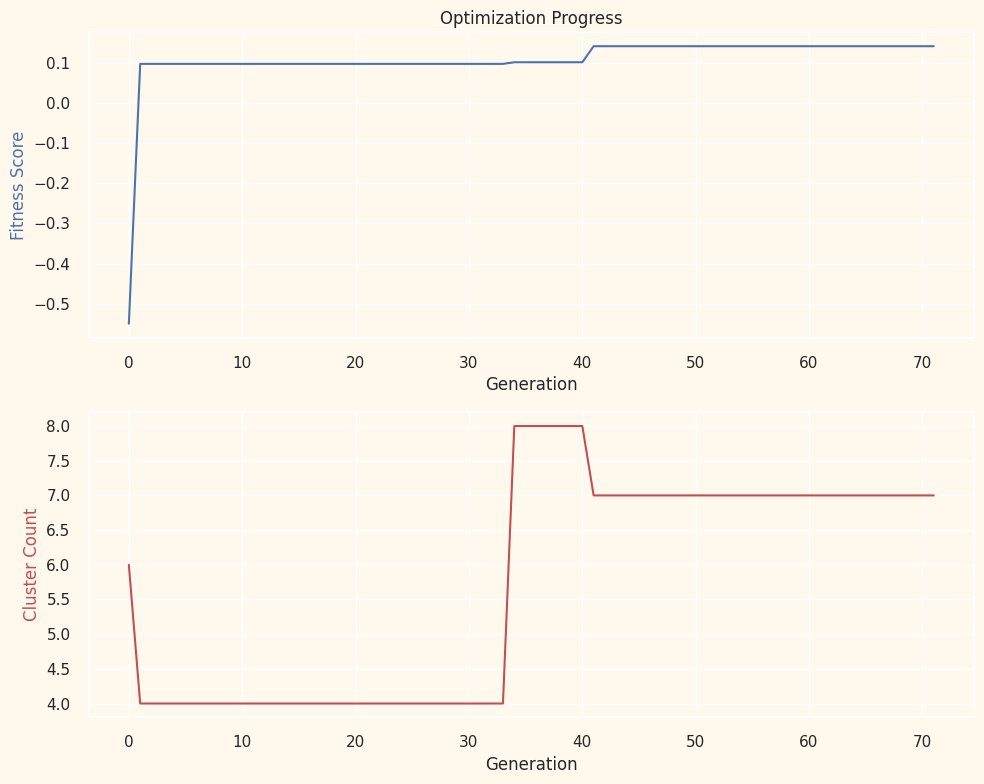

In [44]:
ga.plot_progress()


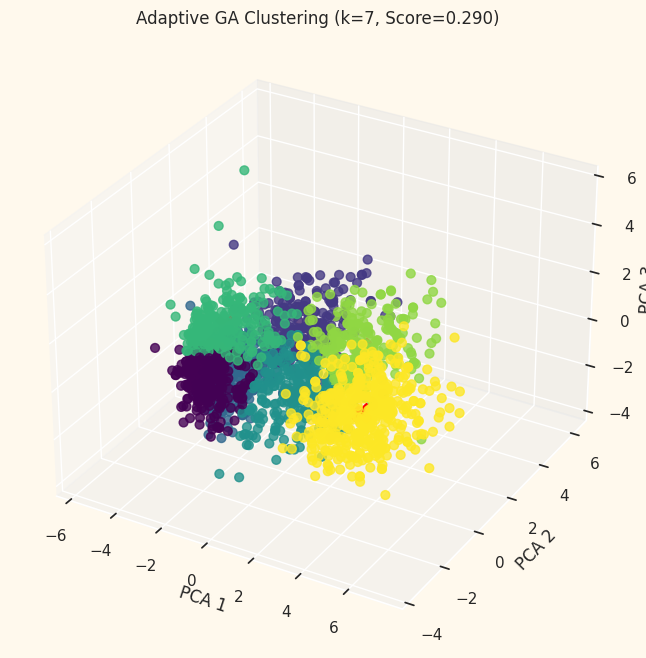

In [45]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

# Use the predicted labels
labels = ga.predict(PCA_ds.values)

# Plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot of data points colored by cluster label
ax.scatter(
    PCA_ds.values[:, 0], PCA_ds.values[:, 1], PCA_ds.values[:, 2],
    c=labels, cmap='viridis', s=40, alpha=0.8
)

# Plot centroids
ax.scatter(
    ga.best_centroids[:, 0], ga.best_centroids[:, 1], ga.best_centroids[:, 2],
    c='red', marker='X', s=200
)

ax.set_title(f"Adaptive GA Clustering (k={ga.best_k}, Score={ga.best_score:.3f})")
ax.set_xlabel("PCA 1")
ax.set_ylabel("PCA 2")
ax.set_zlabel("PCA 3")

plt.show()


In [46]:
# Usage Example
ga = AutoClusterGA(
    max_clusters=8,
    pop_size=70,
    max_gens=200,
    elite_frac=0.1,
    mutation_range=(0.1, 1),
    crossover_range=(0.6, 1),
    n_jobs=-1
)

ga.fit(PCA_ds.values)
labels = ga.predict(PCA_ds.values)

print(f"\nOptimal clusters found: {ga.best_k}")
print(f"Final silhouette score: {ga.best_score:.3f}")

Gen   0: Best k=2 Score=-0.148 Mut=0.57 Cross=0.78
Gen  10: Best k=4 Score=0.123 Mut=0.85 Cross=0.74
Gen  20: Best k=4 Score=0.123 Mut=0.85 Cross=0.70
Gen  30: Best k=4 Score=0.123 Mut=0.82 Cross=0.68
Gen  40: Best k=4 Score=0.123 Mut=0.75 Cross=0.70
Gen  50: Best k=4 Score=0.123 Mut=0.70 Cross=0.71
Early stopping at generation 51

Optimal clusters found: 4
Final silhouette score: 0.329


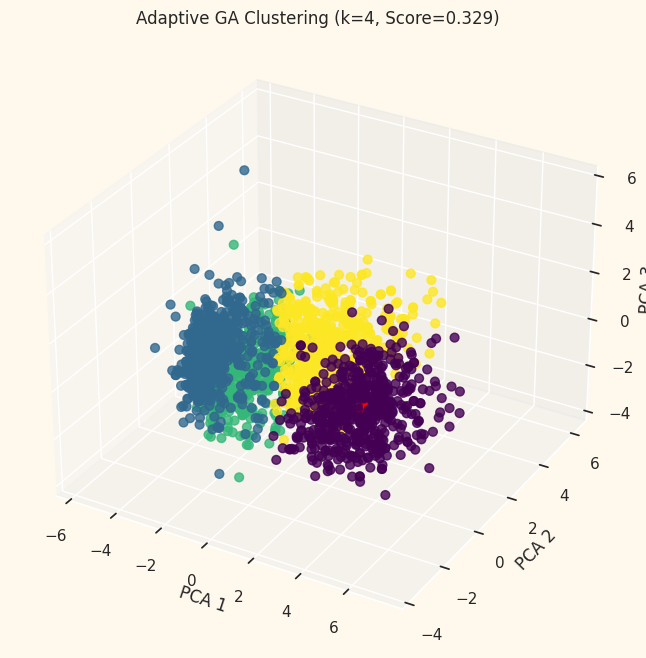

In [47]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

# Use the predicted labels
labels = ga.predict(PCA_ds.values)

# Plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot of data points colored by cluster label
ax.scatter(
    PCA_ds.values[:, 0], PCA_ds.values[:, 1], PCA_ds.values[:, 2],
    c=labels, cmap='viridis', s=40, alpha=0.8
)

# Plot centroids
ax.scatter(
    ga.best_centroids[:, 0], ga.best_centroids[:, 1], ga.best_centroids[:, 2],
    c='red', marker='X', s=200
)

ax.set_title(f"Adaptive GA Clustering (k={ga.best_k}, Score={ga.best_score:.3f})")
ax.set_xlabel("PCA 1")
ax.set_ylabel("PCA 2")
ax.set_zlabel("PCA 3")

plt.show()


In [53]:
# Usage Example
ga = AutoClusterGA(
    max_clusters=8,
    pop_size=65,
    max_gens=200,
    elite_frac=0.1,
    mutation_range=(0.1, 1),
    crossover_range=(0.6, 1),
    n_jobs=-1
)

ga.fit(PCA_ds.values)
labels = ga.predict(PCA_ds.values)

print(f"\nOptimal clusters found: {ga.best_k}")
print(f"Final silhouette score: {ga.best_score:.3f}")

Gen   0: Best k=2 Score=0.326 Mut=0.54 Cross=0.78
Gen  10: Best k=2 Score=0.326 Mut=0.21 Cross=0.80
Gen  20: Best k=2 Score=0.453 Mut=0.15 Cross=0.79
Gen  30: Best k=2 Score=0.598 Mut=0.14 Cross=0.88
Gen  40: Best k=2 Score=0.598 Mut=0.14 Cross=0.88
Gen  50: Best k=2 Score=0.598 Mut=0.13 Cross=0.88
Early stopping at generation 55

Optimal clusters found: 2
Final silhouette score: 0.470


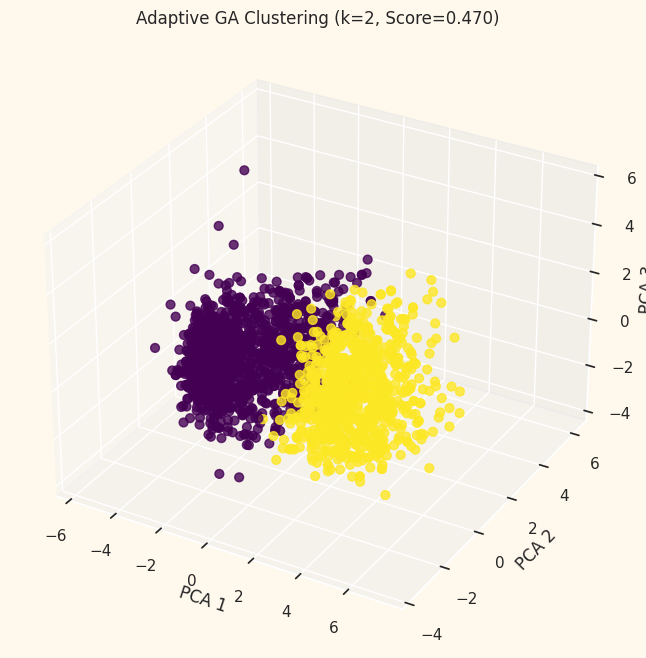

In [51]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

# Use the predicted labels
labels = ga.predict(PCA_ds.values)

# Plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot of data points colored by cluster label
ax.scatter(
    PCA_ds.values[:, 0], PCA_ds.values[:, 1], PCA_ds.values[:, 2],
    c=labels, cmap='viridis', s=40, alpha=0.8
)

# Plot centroids
ax.scatter(
    ga.best_centroids[:, 0], ga.best_centroids[:, 1], ga.best_centroids[:, 2],
    c='red', marker='X', s=200
)

ax.set_title(f"Adaptive GA Clustering (k={ga.best_k}, Score={ga.best_score:.3f})")
ax.set_xlabel("PCA 1")
ax.set_ylabel("PCA 2")
ax.set_zlabel("PCA 3")

plt.show()


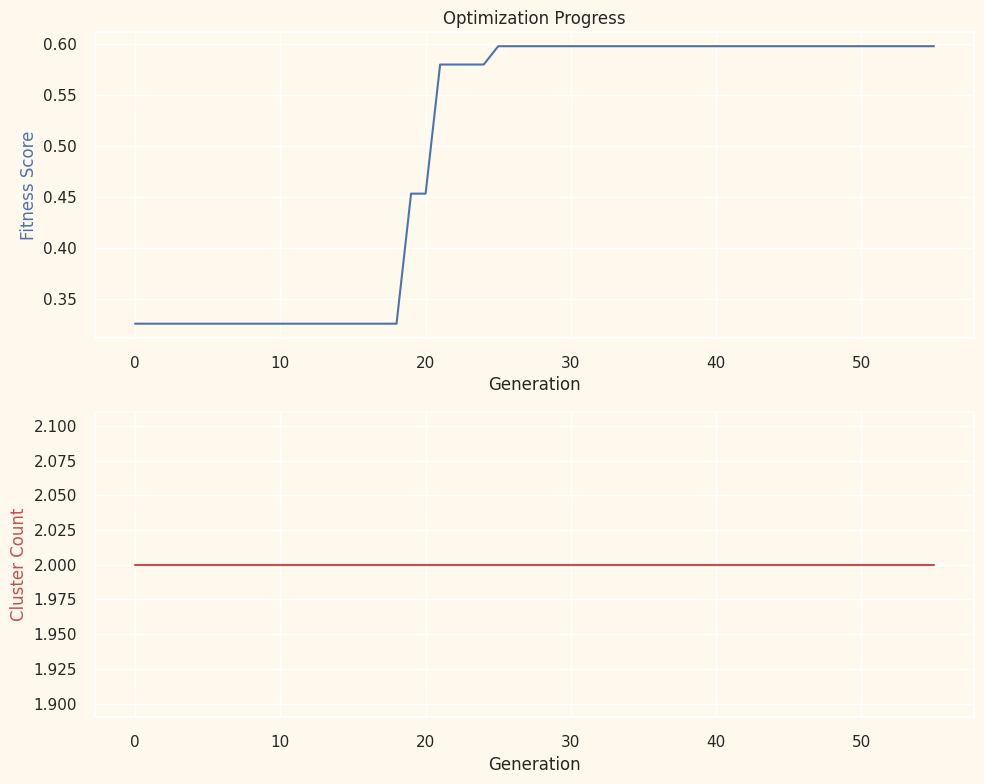

In [54]:
ga.plot_progress()
